<a href="https://colab.research.google.com/github/MattValSE/AutoML2024_Team5/blob/main/AutoML_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook consists of 2 parts:

1.   Bayesian optimization
2.   An attempt to implement the EPSGO algorithm

The second part tries to compare the two results \
We also compare it to Gridsearch \
[Presentation](https://docs.google.com/presentation/d/e/2PACX-1vRBlHngMFC8nawaoAkQwtpz9y07YJW01LA1vfOb4nGJ-I9acvzF-BtPOq0JxqOxc47Q2CZpqN2rrcYn/pub?start=false&loop=false&delayms=3000)




In [1]:
!pip install scikit-optimize
!pip install pyDOE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=d77d7365e471c5cd1b17c72aa74c0fb081fed82adcc621c66e0233444e788246
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import matplotlib.pyplot as plt


# Bayesian optimization


In [3]:
# Load the dataset (e.g., Iris dataset)
data = datasets.load_iris()
X = data.data
y = data.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the SVM model's hyperparameter space
space = [Real(1e-6, 100.0, "log-uniform", name='C'),
         Real(1e-6, 100.0, "log-uniform", name='gamma')]

# Define the objective function to minimize
@use_named_args(space)
def objective(**params):
    # Create the SVM model with the given hyperparameters
    model = SVC(C=params['C'], gamma=params['gamma'])

    # Perform cross-validation and calculate the mean accuracy
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    # Return the negative accuracy (because we want to minimize the objective)
    return -accuracy


In [4]:
# Run Bayesian optimization to find the best hyperparameters
result = gp_minimize(objective, space, n_calls=50, random_state=42)
#print(result)

# Extract the optimal hyperparameters
best_C = result.x[0]
best_gamma = result.x[1]
print(f"Optimal hyperparameters: C = {best_C}, gamma = {best_gamma}")


Optimal hyperparameters: C = 5.094785234755079, gamma = 0.0713002448227164


In [5]:
# Train the final model with the optimal hyperparameters
final_model = SVC(C=best_C
                  #125.8925
                  , gamma=best_gamma)
final_model.fit(X, y)

# Evaluate the model
accuracy = cross_val_score(final_model, X, y, cv=5, scoring='accuracy').mean()
print(f"Cross-validated accuracy of the final model: {accuracy:.2f}")


Cross-validated accuracy of the final model: 0.98


# Implemented algorithm

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore the specific FutureWarning from LogisticRegression
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

# Ignore ConvergenceWarning if needed
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from pyDOE import lhs
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.optimize import direct

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Step 1: Define the objective function (generalization error function Q)
def objective_function(params):
    # params[0] represents the regularization parameter C
    C = 10 ** params[0]  # Transform to log scale
    # Train a logistic regression model with the given C
    model = LogisticRegression(C=C, max_iter=200, solver='liblinear', multi_class='ovr')
    # Compute the negative cross-validation accuracy (to minimize)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return -np.mean(scores)  # We negate because we want to minimize this value

# Step 1: Sample N = 10D initial points from the parameter space
def initialize_sample(D, N):
    # Generate samples using LHS within bounds [-3, 3]
    samples = lhs(D, samples=N, criterion='center')  # 'center' for centered points
    samples = samples * 6 - 3  # Scale to [-3, 3] for log C
    return samples

# Step 2: Compute generalization error Q(pi) for each set of parameters
def compute_errors(sample_points):
    return np.array([objective_function(p) for p in sample_points])

# Step 3: Find Q_min and p_hat
def find_best_parameters(errors, sample_points):
    Q_min = np.min(errors)
    p_hat = sample_points[np.argmin(errors)]
    return Q_min, p_hat

# Step 4: Train the Gaussian Process model on the points (pi, Q(pi))
def train_gp(sample_points, errors):
    kernel = RBF(length_scale=2.5) # radial basis function kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(sample_points, errors)
    return gp

# Step 5: Expected Improvement (EI) acquisition function

def expected_improvement(X, gp, Q_min, xi=0.01): # Change to xi = 0
    mu, sigma = gp.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    mu = mu.reshape(-1, 1)

    with np.errstate(divide='warn'):
        imp = mu - Q_min - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

# Optimization of acquisition function
# I think here we should also have the Scipy implementation of Direct
def propose_location(gp, sample_points, Q_min, bounds, errors):
    def min_obj(X):
        return -expected_improvement(X.reshape(1, -1), gp, Q_min)

    # Start from the best point found so far
    start_point = sample_points[np.argmin(errors)]
    result = direct(min_obj, bounds)
    #result = minimize(min_obj, start_point, bounds=bounds, method='L-BFGS-B')
    return result.x

# Step 6: Update the parameter list and continue until convergence
def bayesian_optimization(D=1, num_iterations=20, tolerance=1e-4):
    # Initial setup
    N = 10 * D
    bounds = [(-3, 3)] * D  # Bounds for the log of C
    sample_points = initialize_sample(D, N)
    errors = compute_errors(sample_points)
    Q_min, p_hat = find_best_parameters(errors, sample_points)

    # Bayesian optimization loop
    for iteration in range(num_iterations):
        # Step 4: Train the Gaussian Process
        gp = train_gp(sample_points, errors)

        # Step 5: Propose a new location
        new_point = propose_location(gp, sample_points, Q_min, bounds, errors)

        # Step 6: Evaluate the objective function at the new point
        new_error = objective_function(new_point)

        # If the new point is better, update Q_min and p_hat
        if new_error < Q_min:
            Q_min = new_error
            p_hat = new_point

        # Step 7: Add the new point to the sample set
        sample_points = np.vstack([sample_points, new_point])
        errors = np.append(errors, new_error)

        # Print progress
        print(f"Iteration {iteration + 1}/{num_iterations}, Q_min: {Q_min:.4f}, p_hat: {10**p_hat[0]:.4f}")

    return Q_min, p_hat

# Function to evaluate a specific C value and return its accuracy
def evaluate_specific_c(specific_c):
    model = LogisticRegression(C=specific_c, max_iter=200, solver='liblinear', multi_class='ovr')
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return np.mean(scores)

# Define the specific value of C for comparison
specific_c_value = best_C

# Run the Bayesian optimization
Q_min, p_hat = bayesian_optimization()
optimal_C = 10**p_hat[0]
#print(f"Optimal regularization parameter C: {optimal_C:.4f}")

# Evaluate the specific C value
highest_accuracy_specific_c = evaluate_specific_c(specific_c_value)
#print(f"Highest Accuracy at C={specific_c_value}: {highest_accuracy_specific_c:.4f}")

# Print out the comparison
print(f"Comparison - Optimal C: {optimal_C:.4f}, Accuracy: {-Q_min:.4f}, \n"
      f"Bayesian optimization C: {specific_c_value:.4f},Bayesian optimization Accuracy : {highest_accuracy_specific_c:.4f}")


Iteration 1/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 2/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 3/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 4/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 5/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 6/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 7/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 8/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 9/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 10/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 11/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 12/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 13/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 14/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 15/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 16/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 17/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 18/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 19/20, Q_min: -0.9800, p_hat: 125.8925
Iteration 20/20, Q_min: -0.9800, p_hat: 125.8925
Comparison - Optimal C: 125.8

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Extract the best regularization parameter C from the optimization result
best_C = 10 ** p_hat[0]
#best_C = 5.094785234755079
# Train the logistic regression model using the optimized parameter
model = LogisticRegression(C=best_C, max_iter=200, solver='liblinear', multi_class='ovr')

# Evaluate the model's accuracy using cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
mean_accuracy = np.mean(scores)

print(f"Optimized regularization parameter C: {best_C:.4f}")
print(f"Cross-validated accuracy with optimized C: {mean_accuracy:.4f}")


Optimized regularization parameter C: 125.8925
Cross-validated accuracy with optimized C: 0.9800


# GridSearch

In [8]:
from sklearn.model_selection import GridSearchCV

# Define a range of values for C (logarithmic scale)
param_grid = {'C': np.logspace(-3, 3, 13)}

# Perform grid search using cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=200, solver='liblinear', multi_class='ovr'),
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Get the best parameter and accuracy from grid search
best_grid_C = grid_search.best_params_['C']
best_grid_accuracy = grid_search.best_score_

print(f"Best C from grid search: {best_grid_C:.4f}")
print(f"Grid search cross-validated accuracy: {best_grid_accuracy:.4f}")


Best C from grid search: 100.0000
Grid search cross-validated accuracy: 0.9800


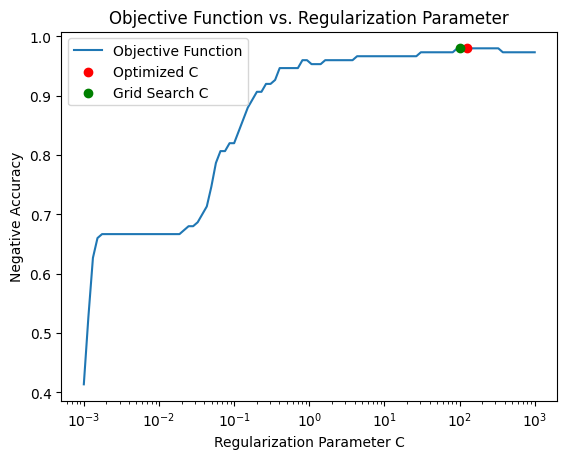

In [9]:
import matplotlib.pyplot as plt

# Evaluate the objective function for a range of values
C_values = np.logspace(-3, 3, 100)
objective_values = [-objective_function([np.log10(C)]) for C in C_values]

# Plot the results
plt.plot(C_values, objective_values, label='Objective Function')
plt.scatter([best_C], [-objective_function([np.log10(best_C)])], color='red', label='Optimized C', zorder=5)
plt.scatter([best_grid_C], [-objective_function([np.log10(best_grid_C)])], color='green', label='Grid Search C', zorder=5)
plt.xscale('log')
plt.xlabel('Regularization Parameter C')
plt.ylabel('Negative Accuracy')
plt.title('Objective Function vs. Regularization Parameter')
plt.legend()
plt.show()


In [10]:
##Earlier attempt
"""
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore the specific FutureWarning from LogisticRegression
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

# Ignore ConvergenceWarning if needed
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF
from pyDOE import lhs
from scipy.optimize import differential_evolution

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Step 1: Define the objective function (generalization error function Q)
def objective_function(params):
    # params[0] represents the regularization parameter C
    C = 10 ** params[0]  # Transform to log scale
    # Train a logistic regression model with the given C
    model = LogisticRegression(C=C, max_iter=200, solver='liblinear', multi_class='ovr')
    # Compute the negative cross-validation accuracy (to minimize)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return -np.mean(scores)  # We negate because we want to minimize this value

# Step 1: Sample N = 10D initial points from the parameter space
def initialize_sample(D, N):
    # Generate samples using LHS within bounds [-3, 3]
    samples = lhs(D, samples=N, criterion='center')  # 'center' for centered points
    samples = samples * 6 - 3  # Scale to [-3, 3] for log C
    return samples

# Step 2: Compute generalization error Q(pi) for each set of parameters
def compute_errors(sample_points):
    return np.array([objective_function(p) for p in sample_points])

# Step 3: Find Q_min and p_hat
def find_best_parameters(errors, sample_points):
    Q_min = np.min(errors)
    p_hat = sample_points[np.argmin(errors)]
    return Q_min, p_hat

# Step 4: Train the Gaussian Process model on the points (pi, Q(pi))
def train_gp(sample_points, errors):
    kernel =  RBF(length_scale=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(sample_points, errors)
    return gp

# Step 5: Expected Improvement (EI) acquisition function
def expected_improvement(X, gp, Q_min, xi=0.01):
    mu, sigma = gp.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    mu = mu.reshape(-1, 1)

    with np.errstate(divide='warn'):
        imp = mu - Q_min - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

# Optimization of acquisition function
def propose_location(gp, sample_points, Q_min, bounds,errors):
    def min_obj(X):
        return -expected_improvement(X.reshape(1, -1), gp, Q_min)
    #print(p_hat,errors)

    # Start from the best point found so far
    start_point = sample_points[np.argmin(errors)]
    result = minimize(min_obj, start_point, bounds=bounds, method='L-BFGS-B')
    return result.x

# Step 6: Update the parameter list and continue until convergence
def bayesian_optimization(D=1, num_iterations=20, tolerance=1e-4):
    # Initial setup
    N = 10 * D
    bounds = [(-3, 3)] * D  # Bounds for the log of C
    sample_points = initialize_sample(D, N)
    errors = compute_errors(sample_points)
    Q_min, p_hat = find_best_parameters(errors, sample_points)
    previous_Q_min = float('inf')

    # Bayesian optimization loop
    for iteration in range(num_iterations):
        # Step 4: Train the Gaussian Process
        gp = train_gp(sample_points, errors)

        # Step 5: Propose a new location
        new_point = propose_location(gp, sample_points, Q_min, bounds,errors)

        # Step 6: Evaluate the objective function at the new point
        new_error = objective_function(new_point)

        # If the new point is better, update Q_min and p_hat
        if new_error < Q_min:
            Q_min = new_error
            p_hat = new_point

        # Step 7: Add the new point to the sample set
        sample_points = np.vstack([sample_points, new_point])
        errors = np.append(errors, new_error)



        # Print progress
        print(f"Iteration {iteration + 1}/{num_iterations}, Q_min: {Q_min:.4f}, p_hat: {10**p_hat[0]:.4f}")

    return Q_min, p_hat

# Run the Bayesian optimization
Q_min, p_hat = bayesian_optimization()
print(f"Optimal regularization parameter C: {10**p_hat[0]:.4f}")
"""

'\nimport warnings\nfrom sklearn.exceptions import ConvergenceWarning\n\n# Ignore the specific FutureWarning from LogisticRegression\nwarnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")\n\n# Ignore ConvergenceWarning if needed\nwarnings.filterwarnings("ignore", category=ConvergenceWarning)\n\nimport numpy as np\nimport pandas as pd\nfrom sklearn.datasets import load_iris\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.gaussian_process import GaussianProcessRegressor\nfrom sklearn.gaussian_process.kernels import Matern\nfrom scipy.optimize import minimize\nfrom scipy.stats import norm\nfrom sklearn.gaussian_process.kernels import RBF\nfrom pyDOE import lhs\nfrom scipy.optimize import differential_evolution\n\n# Load the Iris dataset\niris = load_iris()\nX = iris.data\ny = iris.target\n\n# Step 1: Define the objective function (generalization error function Q)\ndef objec

In [11]:
# Plot the convergence of the optimization process
#plt.plot(-np.array(result.func_vals), marker='o')
#plt.xlabel('Iteration')
#plt.ylabel('Cross-validated Accuracy')
#plt.title('Convergence of Bayesian Optimization')
#plt.grid()
#plt.show()
